# 手把手带你从0开始写一个Transformer

In [2]:
import os
import math
import copy

from IPython.display import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


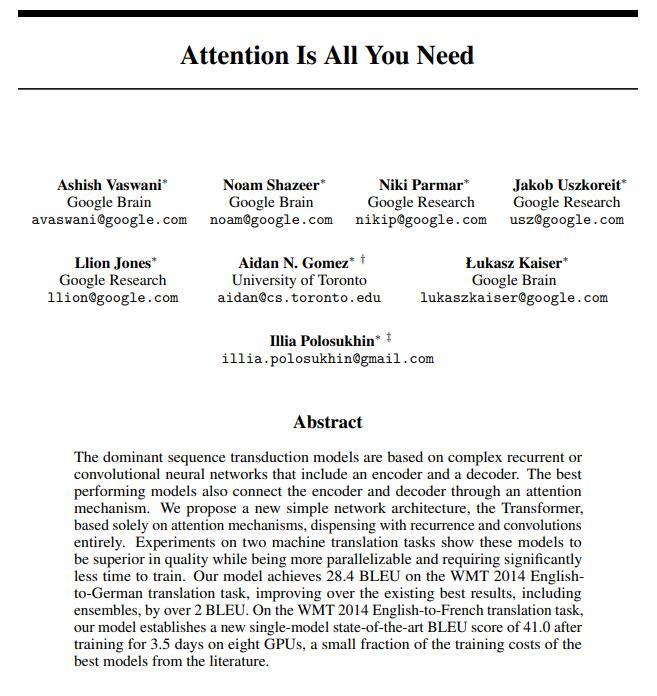

In [3]:
Image(filename='./images/transformer.jpg')

  Transformer 一经提出，在NLP领域引起了巨大轰动，正如他的题目所言 "[Attention is all you need](https://arxiv.org/abs/1706.03762)", 这个工作完全摒弃了之前RNN等时序模型，完全使用注意力机制来进行序列建模。这个工作除了在机器翻译质量上面有了巨大的提升，并且为其他领域提供了一种新的完全基于注意力机制的结构，如随后发展起来的[BERT](https://arxiv.org/abs/1810.04805)，各种[BERT的变形和改进](https://arxiv.org/abs/2009.06732)，以及在视觉领域应用Transformer （"[A Survey on Visual Transformer](https://arxiv.org/abs/2012.12556)"）,论文写的很精彩和清晰，但是初次读论文的我们可能会对论文中的一些公式符号并不是很明白，导致很难将其正确的实现。

  因此在本文中，我将带领大家一步一步从0搭建一个完整的Transformer模型，我将从自底向上以及自顶向下两种方式来分别讲述如何实现和编码Transformer，讲述过程中论文中公式我会以截图给出方便说明，对于每一个类和函数我会尽量表达清楚他的输入输出以及向量维度。本文代码参考了哈佛[havardnlp](https://github.com/harvardnlp/annotated-transformer),对其做一个中文版的描述，方便大家学习。

## 1.背景和一些预先知识
本文中，我们以机器翻译的任务作为实际任务来完成transformer的构建，你需要大致了解机器翻译的架构以及一些pytorch的语法知识。这里我将会从自底向上的方式来讲述它，不过在这之前，我们需要明确我们的目标任务，我们的目标是做机器翻译，输入是一种语言的文本，输出是另一种语言的文本。（本文中以中英翻译举例子）

### 1.1预处理阶段
在预处理阶段，我们需要做的是两件事情，（1）构建我们的词典，（2）将我们的语料库切割成一句一句的对应。

#### 1.1.1构建词典：
这个过程比较简单，简单点你可以理解为，我们对整个语言的语料库进行分词，然后把所有分词的结果放入一个集合当中，那么我们就会得到一个字典，这个字典每一行代表一个分词的实体，具体来看一个公开的字典集合张这个样子：


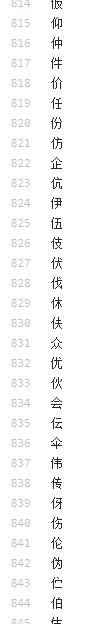

In [4]:
Image(filename='./images/google_zh.jpg')

这个字典构建好以后，我们就可以使用他的id来代表这个字，使得计算机可以理解和处理。还有一个问题，我们在训练过程中是一小批一小批数据来进行处理的，每一句的长短各不相同，但是向量处理又需要所有的样本保持对齐,因此，在字典中有一些特殊的符号来代表mask和pad以及一些其他的特殊符号。如下图的表示：

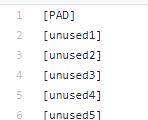

In [5]:
Image(filename='./images/pad.jpg')

#### 1.1.2 Tokenizer
字典建立完成后，我们就可以将输入转化为这样的一种id表示符号的输入，这个过程就是大家经常听到的Tokenizer的过程

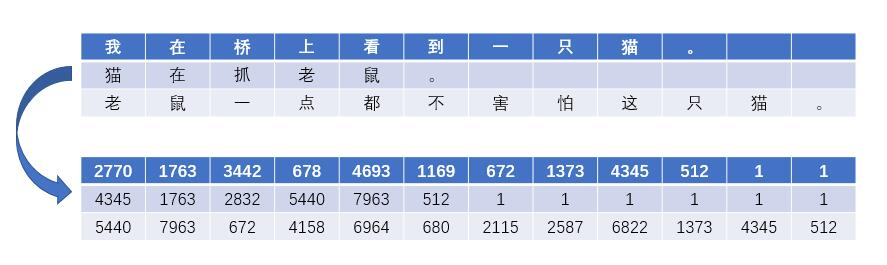

In [6]:
Image(filename='./images/dic.jpg')

到目前为止，我们知道了我们的输入如何用张量来表示$input\in \mathcal{R^{B\times L}}$,其中$B$就是代表我们的batchsize，$L$为每个样本的最大长度，不够最大长度的样本都用\[pad\]补全,字典来源于google_zh_vocab.txt

#### 1.2 结构
接下来就带大家从底向上，从输入$input$开始一步一步搭建起来下图这个结构。

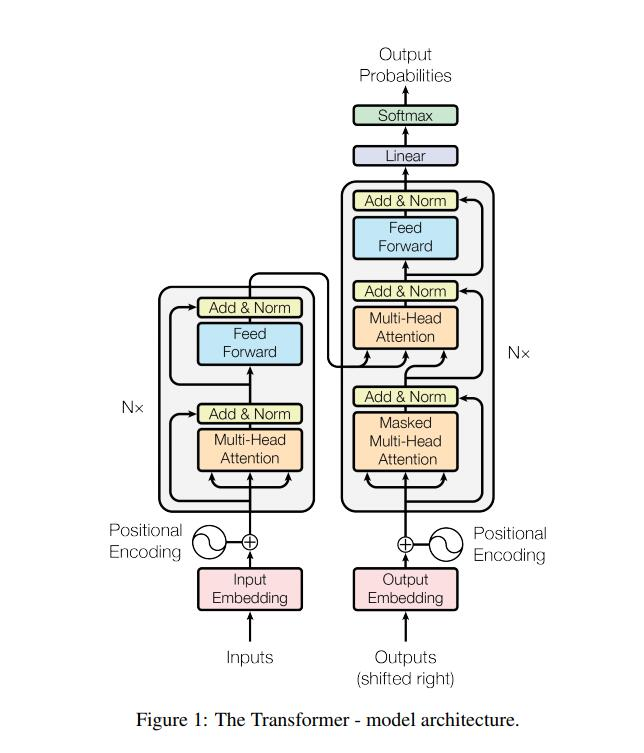

In [7]:
Image(filename='./images/arc.jpg')

## 2.Transformer

### 2.1EmbeddingLayer
在上一小节讲解了输入的形式，输出的形式也大同小异，$input$和输出$output$他们表示都是一致的，从Transformer结构图中，我们可以看出首先经过的就是一个Embedding层，这一层就是将我们输入的每一个id用一个向量来表示，最经典的方法是word2vec，讲大白话就是一个查表的过程，看看id是多少，然后把那个向量取出来。


In [9]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    def forward(self, x):
        return self.lut(x) *math.sqrt(self.d_model)#注意这个小细节，后面将attention时候和这里大同小异，会说明，到时候回来看

上述就是Embedding层的具体是实现。其中$d_model$就是表示每一个id所取出来的向量的大小，$vocab$表示的是我们的字典的大小，也就是字典的容量。数学表达看就是$self.lut\in \mathcal{R^{vocab\times d_{model}}}$, 经过这一层后，输入输出就可以增加一个维度，原始的$inputs,outputs\in \mathcal{R^{B\times L}}$ ，$Embinputs =Embedding(inputs),Emboutputs =Embedding(outputs)$ ,经过embedding层后的输出维度为$Embinputs,Emboutputs\in \mathcal{R^{B\times L\times d_{model}}}$。

